In [29]:
from pyradiosky import SkyModel, utils
import numpy as np
from astropy.table import Table, setdiff
from astropy.utils.diff import report_diff_values
from astropy.io import fits
from operator import itemgetter
import numpy.polynomial.polynomial as poly
import plotly.graph_objects as go
import psutil
import erfa
import csv
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import itertools
import os
from PIL import Image
from fpdf import FPDF

sm = SkyModel()

#gleam_catalog = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "subband", with_error = True)
#gleam_spectral_index = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "spectral_index", with_error = True)

In [2]:
def log_linear_fit(freqs, fit_data, stokes_error, dec, catalog, detect_outlier = False):
    """
    This is the fit modeling function. It compute combined error, fits the log of source data to a linear
    polynomial, and calculates a chi2 residual. It can also perform an outlier analysis, to see if any
    significant outliers exist for a given source.
    
    
    Parameters
    ----------
    freqs : ndarray
        Frequencies available for the source.
    fit_data : ndarray
        Fluxes for available frequencies.
    stokes_error : ndarray
        The error for the source in the catalog.
    dec : ndarray
        Declination of the source. Total error is a combination of the stokes_error and an
        error calculated from the declination of the source.
    detect_outlier : bool
        Will test the source data to determine if there is a significant outlier that affects the
        fit. When 'detect_outlier'=True, fits on all points, then determines the greatest outlier from
        the first fit by detetermining the largest residual from the first fit. Fits again without this
        outlier. If the reduced chi2 is improved by more than 2.6x, the outlier is removed and the fit
        without this point is used.
        
    Returns
    -------
    coeffs : ndarray
        Coefficients of the linear fit of data. A pair of numbers, [b, m] corresponding to the equation
        y=b+mx
    chi2_residual : float
        The reduced chi^2 value for the fit. When 'detect_outlier'=True, the chi2_residual of the better fit
    fitted_data : ndarray
        Modeled fluxes at only the frequencies provided in 'freqs'
    all_freqs_fitted_data : ndarray
        Modeled fluxes at all GLEAM frequencies
    fitted_freqs : ndarray
        Only frequencies that are used in the fit
    fit_data_selected : ndarray
        Fluxes corresponding to the 'fitted_freqs' frequencies. Sometimes there are NaN values in
        only one of fluxes or errors, so this removes those datapoints. This usually happens if
        the flux at a frequency was negative, and has been turned into a NaN.
    original_parameters : ndarray
        If an outlier is determined and the outlier-removed fit is superior to the full fit, an array containing
        the fit parameters that included the outlier. If there is no outlier, 'original_parameters'=NaN
    low_fit : float
        The projected flux at 50 MHz. This is useful if you want to see how the extrapolation of the fit
        performs outside GLEAM's frequency range.
    """
    
    # Calculate sky coordinate-based portion of error
    if (dec >= 18.5) or (dec <= -72):
        loc_error = fit_data * .03
    else:
        loc_error = fit_data * .02
    
    # Compute total error and weight for the polyfit
    total_error = np.sqrt(loc_error**2 + stokes_error**2)
    
    #with warnings.catch_warnings():
            
        # Ignore warnings caused by some sources having 1 or 0 data points
    #    warnings.filterwarnings(action = "ignore", message="Degrees of freedom <= 0 for slice.")
    #    warnings.filterwarnings(action = "ignore", message="divide by zero encountered in log10")
            
    weight = np.log10(1 / total_error)
    
        # Convert data into log scale for polyfit
    fit_data_log = np.log10(fit_data)
    freqs_log = np.log10(freqs)
    all_freqs_log = np.log10(catalog.freq_array.value)
    
    # Subset to freqs with no nans in vals or errors and do polyfit on only those freqs
    idx = np.isfinite(freqs_log) & np.isfinite(fit_data_log) & np.isfinite(weight)
    
    # coeffs is a pair of numbers (b, m) corresponding to the equation y=b+mx
    coeffs = poly.polyfit(freqs_log[idx], fit_data_log[idx], w = weight[idx], deg=1)
    
    # Use coeffs to generate modeled vals at only freqs that were used to make coeffs
    fit_log = poly.polyval(freqs_log[idx], coeffs)
    fitted_data = 10**fit_log
    
    # use coefficients to generate modeled vals at all 20 freqs
    full_fit_log = poly.polyval(all_freqs_log, coeffs)
    all_freqs_fitted_data = 10**full_fit_log
    
    # generate modeled val at 50 MHz
    low_fit_log = poly.polyval(np.log10(50000000), coeffs)
    low_fit = 10**low_fit_log
    
    #compute reduced chi2 value
    variance = total_error[idx]**2
    residual = fit_data[idx] - fitted_data
    chi2 = sum((residual**2) / variance)
    chi2_residual = chi2 / (len(freqs[idx]) - 2)
    
    fitted_freqs = freqs[idx]
    fit_data_selected = fit_data[idx]
    
    original_parameters = np.array([[float("NaN")]])
    
    # Outlier detection reruns fit without greatest outlier
    if detect_outlier == True:
        idx_outlier = np.argmax(abs(residual))
        
        # create datasets with outlier removed
        log_data_ol = np.delete(fit_data_log[idx], idx_outlier)
        log_freq_ol = np.delete(freqs_log[idx], idx_outlier)
        weight_ol = np.delete(weight[idx], idx_outlier)
        
        #fit without the outlier
        coeffs_ol = poly.polyfit(log_freq_ol, log_data_ol, w = weight_ol, deg=1)
        
        fit_log_ol = poly.polyval(log_freq_ol, coeffs_ol)
        fitted_data_ol = 10**fit_log_ol
        full_fit_log_ol = poly.polyval(all_freqs_log, coeffs_ol)
        all_freqs_fitted_data_ol = 10**full_fit_log_ol
        
        # compute chi2 using this new fit
        variance_ol = np.delete(total_error[idx], idx_outlier)**2
        residual_ol = np.delete(fit_data[idx], idx_outlier) - np.delete(fitted_data, idx_outlier)
        
        chi2_ol = sum((residual_ol**2) / variance_ol)
        chi2_residual_ol = chi2_ol / (len(np.delete(freqs[idx], idx_outlier)) - 2)
        

        # see if fit has improved
        if chi2_residual_ol < chi2_residual / 2.6:
            
            original_parameters = np.array([coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, fitted_freqs, fit_data_selected], dtype=object)
            
            #reassign values with outlier removed version of fit
            chi2_residual = chi2_residual_ol
            coeffs = coeffs_ol
            fitted_data = fitted_data_ol
            all_freqs_fitted_data = all_freqs_fitted_data_ol
            fitted_freqs = np.delete(freqs[idx], idx_outlier)
            fit_data_selected = np.delete(fit_data[idx], idx_outlier)

    return(coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, fitted_freqs, fit_data_selected, original_parameters, low_fit)


def low_freq_fit(catalog_loc, flux_threshold = 1, sources_list = None, save_csv = None):
    """
    This function performs a multi-layered fit of the GLEAM catalog sources with a preference for low frequencies.
    A fit is always based on at least 4 data points.
    For a given source;
        1. Replace any negative fluxes with NaN's
        2. Run 'log_linear_fit' function on source data, checking for significant outliers.
        3. If the source is >1 Jy at 150 MHz, and if the reduced chi2 of the fit is >= 1.93, run 'log_linear_fit'
        again, on only the bottom half of available frequencies for the source. Sources dimmer than 1 Jy do not
        show much fit improvement by reducing the number of frequencies, because their scatter is high.
        4. If the reduced chi2 of the fit of the bottom half of frequencies is still >= 1.93, AND there are at
        least 8 frequencies in the bottom half of frequencies, run 'log_linear_fit' a third time on only the
        bottom quarter of frequencies for the source.
        5. If the reduced chi2 is still >= 1.93, the fit with the lowest chi2 is selected as the best fit.
        6. Parameters and data for the best/final fit are put into a dict, which also includes a keyword whose
        value is the relevant parameters of any previous fits.
    
    Parameters
    ----------
    catalog_loc : str
        The full file location of the gleam catalog.
    flux_threshold : float
        The flux threshold at 150 MHz above which multiple fits are allowed. Dim sources tend to have a lot
        of scatter across frequencies and reducing the number of datapoints by performing multiple fits
        usually results in a fit that doesn't resemble the overall data trend for these sources.
    sources_list : list
        A list of specific sources. This is most useful if you want to look at sources you've noted using the
        plotFits function, but could be used on any list of sources.
    save_csv : str
        The path to the folder to save a csv of the fit data. 
        
    Returns
    -------
    source_dict : dict
        A dictionary containing dicts of the data and parameters for the best fit for each source.
        For a given source, the dict contains:
            ra : ndarray
                The Right Ascension of the source
            dec : ndarray
                The declination of the source.
            coefficients : ndarray
                The coefficients of the best fit, [b, m] corresponding to y=b+mx, the linear fit of logged
                source data.
            chi2_residual : float
                The reduced chi2 value of the best fit of the source.
            prev_fit_data : list
                Data from previous fits that were not the best fit. If a source did not have a specific fit,
                the value is NaN. For example if there were only a full and half fit, values corresponding
                to the quarter fit will be NaN.
                This contains, in order:
                1. Data for all frequencies 'all_freqs_fitted_data' from full fit
                2. Data for all frequencies from half fit
                3. Data for all frequencies from quarter fit
                4. Chi2 residual 'chi2_residual' from full fit
                5. Chi2 residual from half fit
                6. Chi2 residual from quarter fit
                7. Data from only provided freqs, from the variable 'fitted_data', from full fit
                8. Data from only provided freqs used in half fit
                9. Data from only provided freqs used in quarter fit
                10. Coefficients from the initial full fit, from the variable 'coeffs'.
        
            fitted_data : ndarray
                Modeled fluxes at only the frequencies provided in the best fit of the source. If the half fit
                is the best, this will just be the data corresponding to the bottom half of frequencies, etc.
            all_freqs_fitted_data : ndarray
                Modeled fluxes at all 20 GLEAM frequencies, even frequencies with no data from the catalog.
            freqs : ndarray
                All 20 frequencies in GLEAM
            freqs_used_for_fit : ndarray
                Only frequencies used in the best fit of the source. If the half fit is the best, this is just the
                bottom half of frequencies, etc. Corresponds to the 'fitted_freqs' output from 'log_linear_fit' 
            data_used_for_fit : ndarray
                Original GLEAM fluxes corresponding to the frequencies used to generate the fit of the source.
            pre_outlier_removal_output : ndarray
                Contains data from the 'original_parameters' output from 'log_linear_fit'. These are all the data, 
                coefficients, etc from a fit where outliers were checked for and if necessary removed, before
                removal. In other words this is the fit if the outlier is present.
            variance : float
                Variance is a measure of the scatter of the original flux data. Flux data is normalized,
                and then the difference between each pair of adjacent points is calculated. The variance describes
                overall how closely aligned adjacent datapoints are. A low variance indicates a low scatter in the
                source across frequencies, and datapoints that follow an overall trend. High variance indicates
                that there is a lot of intrinsic data scatter. This can be useful in looking at overall goodness of
                fit, since we'd expect sources with a lot of intrinsic scatter and therefore a high variance to
                have mediocre fits due to data quality issues, rather than the fit itself being at fault.
                Conversely, a poor fit on a source with low variance would be something to be concerned about.
            50_mhz_extrapolation : list
                 - Projected flux at 50 MHz for the best of all fits performed.
                 - Projected flux at 50 MHz for the initial fit on all available frequencies.
    Output
    ------
    If 'save_csv' is not None, a csv of 'source_dict' will be saved in the location specified with the
    'save_csv' kwarg.
    
    """
    gleam_catalog = sm.from_gleam_catalog(catalog_loc, spectral_type = "subband", with_error = True)
    
    #Initialize arrays used in function
    source_dict = {}
    bad_chi2 = []
    problem_objs = []
    
    # If a list of sources is given, create array of those sources. Otherwise use an ordered list of length
    # equal to the total Ncomponents in gleam.
    if sources_list == None:
        r_sources = np.arange(gleam_catalog.Ncomponents)
    else:
        r_sources = np.asarray(sources_list)
        
    # Fit each source.
    for source in r_sources:
        
        fit_data = gleam_catalog.stokes.value[0,:,source]
        dec = gleam_catalog.dec.value[source]
        freqs = gleam_catalog.freq_array.value
        stokes_error = gleam_catalog.stokes_error.value[0,:,source]

        # Normalize data to calc variance
        mean_adj_data = (fit_data - np.nanmean(fit_data)) / np.nanmean(fit_data) 
        
        # Calculate variance between fluxes for final dict
        diff = np.diff(mean_adj_data)
        source_variance = np.nanvar(diff)

        #Initialize arrays for half and quarter fits
        out2 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])
        out3 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])

        # Find sources that have missing values in only one of error and vals
        source_probs = []
        for i in range(len(fit_data)):
            if np.isnan(fit_data[i]):
                if ~np.isnan(stokes_error[i]) and not source_probs:
                    source_probs.append([fit_data, stokes_error])
            else:
                if np.isnan(stokes_error[i]) and not source_probs:
                    source_probs.append([fit_data, stokes_error])

        # Only include source in problems list if there WAS a problem, exclude source from all subsequent fitting
        if source_probs:
            problem_objs.append([source, gleam_catalog.ra.value[source], gleam_catalog.dec.value[source], source_probs])
            continue

        # Eliminate negative fluxes by turning into nans before fitting
        fit_data[fit_data < 0] = np.nan
        indices = np.argwhere(~np.isnan(fit_data)).flatten()

        # Skip sources with zero fluxes (can happen if there were a small number of negative fluxes for the source)
        if np.all(np.isnan(fit_data)):
            continue

        # Perform full fit using all freqs available for source, testing for outliers
        out1 = log_linear_fit(freqs, fit_data, stokes_error, dec, catalog=gleam_catalog, detect_outlier = True)
        
        #Transfer output to 'out', which is the final output variable, to save results from this fit in out1
        out = out1

        # if chi2_residual is >=1.93 and brighter than 1Jy at 150MHz, fit again with fewer freqs
        if out[1] >= 1.93:
            if fit_data[9]>=flux_threshold:

                # Fit with bottom half of freqs
                if len(fit_data[indices]) >= 8:
                    half_freqs = freqs[indices[:int(len(indices) / 2)]]
                    fit_data_half = fit_data[indices[:int(len(indices) / 2)]]
                    error_half = stokes_error[indices[:int(len(indices) / 2)]]

                    out2 = log_linear_fit(half_freqs, fit_data_half, error_half, dec, catalog=gleam_catalog)
                    out = out2

                    # if half fit has poor chi2, fit with bottom 1/4 freqs
                    if out[1] >= 1.93:
                        
                        # If there are >=16 total non-nan frequencies, fit on bottom 1/4
                        if len(half_freqs) >= 8:
                            qt_freqs = half_freqs[:int(len(half_freqs) / 2)]
                            fit_data_qt = fit_data_half[:int(len(half_freqs) / 2)]
                            error_qt = error_half[:int(len(half_freqs) / 2)]

                            out3 = log_linear_fit(qt_freqs, fit_data_qt, error_qt, dec, catalog=gleam_catalog)
                            out = out3

                        # If there are <16 total non-nan frequencies, fit on bottom 4 frequencies
                        else:
                            bottom_freqs = freqs[indices[:4]]
                            fit_data_bottom = fit_data[indices[:4]]
                            error_bottom = stokes_error[indices[:4]]

                            out3 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec, catalog=gleam_catalog)  
                            out = out3

                else:
                    # If bottom half of freqs is <8, run "half" fit on bottom 4 freqs, and do not attempt 3rd fit
                    bottom_freqs = freqs[indices[:4]]
                    fit_data_bottom = fit_data[indices[:4]]
                    error_bottom = stokes_error[indices[:4]]

                    out2 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec, catalog=gleam_catalog)
                    out = out2


        # if chi2_residual is still >=1.93 after all iterations, keep fit with lowest chi2 as the best fit
        if out[1] >= 1.93:
            bad_chi2.append([source, out1[3], out2[3], out3[3], out1[1], out2[1], out3[1]])

            # select best of 3 fit options by chi2 val and use as final fit
            prev_rounds = {"out1": out1[1], "out2": out2[1], "out3": out3[1]}
            best_fit = min(prev_rounds, key=prev_rounds.get)
            out = eval(best_fit)

        # Create dict with final vals
        source_vars = {
            "ra": gleam_catalog.ra.value[source],
            "dec": dec,
            "coefficients": out[0],
            "chi2_residual": out[1],
            "prev_fit_data": [out1[3], out2[3], out3[3], out1[1], out2[1], out3[1], out1[2], out2[2], out3[2], 
                              out1[0]],
            "fitted_data": out[2],
            "all_freqs_fitted_data": out[3],
            "freqs": freqs,
            "freqs_used_for_fit": out[4],
            "data_used_for_fit": out[5],
            "pre_outlier_removal_output": out[6],
            "variance": source_variance,
            "50_mhz_extrapolation": [out[7], out1[7]]
        }
        
        # source_dict is a dict of dicts
        source_dict[source] = source_vars
    
    # Create csv of results of fitting
    if save_csv is not None:
        fit_output = pd.DataFrame(source_dict).T
        fit_output.to_csv(save_csv + "gleam_catalog_fits_" + str(flux_threshold) + "jy.csv")
        
    return(source_dict, problem_objs)

In [3]:
source_fits, problem_objs  = low_freq_fit(catalog_loc = "/Users/Kiana1/uwradcos/gleam.vot")

Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in log10


In [ ]:
no_threshold_fits = low_freq_fit(catalog_loc = "/Users/Kiana1/uwradcos/gleam.vot", flux_threshold = 0)

In [53]:
def spectral_ind_dist(source_dict, plot_type='diff', flux_threshold = 1, save_loc = None):
    """
    Creates a 2D histogram of the distribution of source brightness at 150 MHz vs spectral index
    
    Parameters
    ----------
    source_dict : dict
        The output from 'low_freq_fit', a dict of data and parameters describing the fits of sources
    plot_type : str
        Which fit iteration spectral index to plot. Must be one of:
        - "diff" (Difference between initial and final fit spectral indices)
        - "first" (Spectral index of initial, all-frequency fits)
        - "final" (Spectral index of final, best fits)
    flux_threshold : float
        Flux threshold used in 'low_freq_fit'. Should be identical to that threshold. Default is 1Jy.
    save_loc : str
        Path of folder to save plots in.
        
    Outputs
    -------
    Plot of brightness distribution on x axis and spectral index (or difference between spectral indices)
    on y axis.
    
    If plot_type = "diff", there will be no sources below the flux threshold specified in 'low_freq_fit',
    because only 1 fit is done at sources dimmer than that threshold.
    
    If "save_loc" is specified, the plot will be saved in that location as:
    "path.../flux150_vs_spectral_index_hist_[plot_type].png"
    
    """
    midband = []
    diff = []
    first = []
    last = []

    for i in source_dict:
        if i in source_dict:
            if plot_type=='diff':
                
                # Ignore sources with only one fit
                if np.isnan(source_dict[i]['prev_fit_data'][1][0]):
                    continue
                
                # Take difference between full fit and final fit
                else:
                    midband.append(source_dict[i]['prev_fit_data'][0][9])
                    first_ind = source_dict[i]['prev_fit_data'][9][1]
                    last_ind = source_dict[i]['coefficients'][1]
                    diff.append(last_ind - first_ind)
            
            # Get data from all-frequency full fits
            elif plot_type=='first':
                midband.append(source_dict[i]['prev_fit_data'][0][9])
                first.append(source_dict[i]['prev_fit_data'][9][1])
                
            # Get data from whatever the best fit was
            elif plot_type=='last':
                midband.append(source_dict[i]['prev_fit_data'][0][9])
                last.append(source_dict[i]['coefficients'][1])
    
    # Plot the given plot type
    if plot_type=='diff':
        plt.hist2d(midband, diff, bins = 100, norm=LogNorm(), range = [[0,5],[-16,16]])
        plt.ylabel("Spectral index diff, [last - first]")
        plt.title("Distribution of source flux vs spectral index, [final - first] fit, multifit threshold: "
                  + str(flux_threshold) + " Jy")

    elif plot_type=='first':
        plt.hist2d(midband, first, bins = 100, norm=LogNorm(), range = [[0,5],[-10,10]])
        plt.ylabel("Spectral index, first fit")
        plt.title("Distribution of source flux vs spectral index, " + plot_type +
              " fit, multifit threshold: " + str(flux_threshold) + " Jy")
        
    elif plot_type=='last':
        plt.hist2d(midband, last, bins = 100, norm=LogNorm(), range = [[0,5],[-10,10]])
        plt.ylabel("Spectral index, final fit")
        plt.title("Distribution of source flux vs spectral index, " + plot_type +
              " fit, multifit threshold: " + str(flux_threshold) + " Jy")
        
    plt.xlabel("150 Mhz flux")

    if save_loc is not None:
        filepath = save_loc + "flux150_vs_spectral_index_hist_" + plot_type + "_" + str(flux_threshold) + "jy.png"
        plt.savefig(filepath)

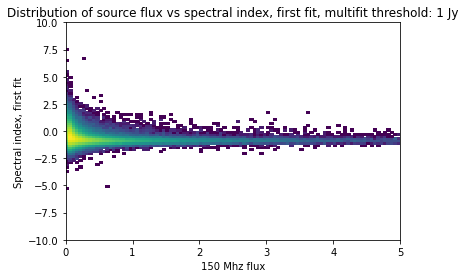

In [56]:
spectral_ind_dist(source_dict = source_fits, plot_type='first', save_loc = '/Users/Kiana1/uwradcos/plots/')

In [42]:
def grouper(n, iterable):
    """
    Creates groups of n over iterable = range(N)
    """
    args = [iter(iterable)] * n
    return ([e for e in t if e is not None] for t in itertools.zip_longest(*args))


def compile_plots(plot_locs, length):
    """
    Compiles all plots with a certain naming convention into a single pdf
    
    Parameters
    ----------
    plot_locs : str
        Full path name to jpgs, excluding the number on the end of the jpg indicating the page number,
        and the .jpg extension itself. 
    length : int
        Number of pages to combine+1. So if 20 pages, length=21.
    Output
    ------
    PDF of all jpg pages combined into one file
    
    
    """
    pdf = FPDF()
    wi,h = 0,0

    # Combining output files 
    for i in range(0, length):
        fname = plot_locs + "%.1d.jpg" % i
        if os.path.exists(fname):
            if i == 0:
                cover = Image.open(fname)
                wi,h = cover.size
                pdf = FPDF(unit = "pt", format = [wi,h])
            image = fname
            pdf.add_page()
            pdf.image(image,0,0,wi,h)
        else:
            print("File not found:", fname)
        print("processed page %d" % i, fname)
    pdf.output(plot_locs + "_all.pdf", "F")
    print("PDF can be found at: " + plot_locs + "_all.pdf")
    

def plotFits(catalog_loc, source_dict, plot_type, order, Nsources=9, savefig=False,
             saveloc="/Users/Kiana1/uwradcos/plots/compare_outlier_spectrums"):
    """
    Creates pages with 9 plots per page of original GLEAM data of whatever subset of sources you select,
    the GLEAM catalog fits for those sources, and the fit results from the 'low_freq_fit' function.
    
    Parameters
    ----------
    catalog_loc : str
        The full path location of the GLEAM catalog
    source_dict : dict
        The first object returned from the 'low_freq_fit' function
    plot_type :  str
        One of the following: 'no_dim', 'bright', 'spect_ind_outliers', 'multi', 'hera_stripe', 'all'.
        1. 'no_dim' - sources above 100 mJ
        2. 'bright' - sources where the all frequency fit is brighter than 1 Jy at 150 MHz
        3. 'spect_ind_outliers' - sources with spectral indices outside of [-2, 1]
        4. 'multi' - sources that were fitted multiple times
        5. 'hera_stripe' - sources that fall in the HERA stripe
        6. 'all' - all sources
    order : str
        One of the following: 'low_freq_compare', 'max_flux', '150mhz_flux', 'chi2', 'spect_ind'. 
        1. 'low_freq_compare' - sorts based on difference between fit extrapolation at 50 MHz of first fit and
        final fit, from largest difference to smallest
        2. 'max_flux' - sorts based on maximum brightness of source, bright to dim
        3. '150mhz_flux' - sorts based on brightness of the initial all-frequency fit at 150 MHz, brightest to dimmest
        4. 'chi2' - based on chi2 value, largest to smallest
        5. 'spect_ind' - sorts based on the absolute value of the final spectral index of the source, largest to smallest.
    Nsources : int
        Number of catalog sources to plot. If less than the total number of sources that fulfill the plot_type is
        given, plots the specified number of plots sorted by the order. For example if Nsources=30 and order=chi2,
        it will plot the 30 largest chi2 sources from large to small.
    savefig : bool
        If True, will save all figures in the folder given by 'saveloc'. Many files are generated, so it's good to
        specify a folder separate from anything else.
    save_loc : str
        The location for all 
        
        
    """
    
    gleam_catalog = sm.from_gleam_catalog(catalog_loc, spectral_type = "subband", with_error = True)
    gleam_spectral_index = sm.from_gleam_catalog(catalog_loc, spectral_type = "spectral_index", with_error = True)
    
    #get sources ordered by max power of points used for final fit
    ordered_power = []
    
    # Select some subset of sources that fall under a criteria given by plot_type
    #for k in np.arange(max(source_dict)):
    for k in source_dict:
        if k in source_dict:
            
            eval_parameter = "r'$Sp-Ind=%.2e$' % (source_dict[source_num]['coefficients'][1])"
            # Create sorting variable
            if order=='low_freq_compare':
                sort_var = source_dict[k]['50_mhz_extrapolation'][0]
                sort_tag = "extrapolated flux at 50 MHz"
                
                eval_parameter = "r'$50MHz-flux=%.2e$' % (source_dict[source_num]['50_mhz_extrapolation'][0])"
                # Do a thing where if this is what we're looking at, it shows sthe diff instead of the
                #spectral index in the box on the plot. Otherwise it shows the spectral index
                
            elif order=='max_flux':
                sort_var = np.nanmax(source_dict[k]['data_used_for_fit'])
                sort_tag = "maximum flux used in fit"
            elif order=='150mhz_flux':
                sort_var = source_dict[k]['prev_fit_data'][0][9]
                sort_tag = "modeled flux at 150 MHz"
            elif order=='chi2':
                sort_var = source_dict[k]['chi2_residual']
                sort_tag = "final X2 value"
            elif order=='spect_ind':
                sort_var = np.abs(source_dict[k]['coefficients'][1])
                print(sort_var)
                sort_tag = "final spectral index"
            else:
                raise ValueError("Must choose one of the following sort methods: 'low_freq_compare', 'max_flux', '150mhz_flux', 'chi2', 'spect_ind'.")
            
            # Subset to sources that fulfill some critera
            if plot_type == 'hera_stripe':
                # Skip objs that are not in HERA stripe
                if 105 <= source_dict[k]['ra'] <= 255:
                    if 26 <= source_dict[k]['dec']<=34:
                        ordered_power.append([sort_var, k])
                        tag = "in Hera Stripe"
                    else:
                        continue
                else:
                    continue
                        
            elif plot_type == 'multi':   
                # skip objs that found good fit first time
                if np.isnan(source_dict[k]['prev_fit_data'][1][0]):
                    continue
                else:
                    ordered_power.append([sort_var, k])
                    tag = "with multiple fits"
            
            elif plot_type == 'no_dim':
                # skip objs where max val is <100mJ
                if np.nanmax(source_dict[k]['data_used_for_fit']) < .1:
                    continue
                else:
                    ordered_power.append([sort_var, k]) 
                    tag = "brighter than 100 mJ"
                
            elif plot_type == 'bright':
                # Skip objs where the all-freq fit is dimmer than 1Jy at 150 MHz
                if source_dict[k]['prev_fit_data'][0][9] < 1:
                    continue
                else:
                    ordered_power.append([sort_var, k])
                    tag = "brighter than 1Jy at 150 MHz"
            
            elif plot_type == 'spect_ind_outliers':
                # skip objs that have close to average spectral indices
                if -2 <= source_dict[k]['coefficients'][1] <= 1:
                    continue
                else:
                    ordered_power.append([sort_var, k])
                    tag = "with Spectral Index outside of [-2,1]"
            
            elif plot_type == 'all':
                ordered_power.append([sort_var, k])

            
    ordered_power = sorted(ordered_power, key=lambda x: x[0], reverse = True)
    
    if Nsources == "all":
        Nsources = len(ordered_power)
    
    #number of pages necessary
    grouped_sources = grouper(9, range(Nsources))

    for j in list(grouped_sources):
        #Page configuration setup
        page = int(max(j) / 9)
        nsources = max(j)+1 / (page + 1)

        fig = plt.figure(figsize=(28,20))
        nrows = 3
        gs = gridspec.GridSpec(3*nrows, 3, height_ratios=np.tile([1,0.4,0.25],nrows))
        plt.subplots_adjust(hspace=.0)
        
        elements = []
        for page_idx,i in enumerate(j):
            # 'plots' is a list of plotting code snippets, which are executed all together once all plots that exist
            # have been determined for a source
            plots = []
            fit = plt.subplot(gs[int((page_idx//3)*9 + page_idx%3)])
            source_num = ordered_power[i][1]
            freqs = source_dict[source_num]['freqs'] / 1000000
            
            # plots the gleam catalog fit
            ref_freq = gleam_spectral_index.reference_frequency.value[source_num] / 1000000
            gleam_fit = gleam_spectral_index.stokes[0,0,source_num]*(freqs/ref_freq)**(gleam_spectral_index.spectral_index[source_num])
            plots.append('fit.plot(freqs, gleam_fit, label="gleam fit", linestyle = ":", color = "#7299FF")')

            # plots the raw gleam data for all frequencies with errorbars 
            raw_data = gleam_catalog.stokes.value[0,:,source_num]
            raw_freqs = gleam_catalog.freq_array.value / 1000000
            stokes_error = gleam_catalog.stokes_error.value[0,:,source_num]
            plots.append('fit.errorbar(raw_freqs, raw_data, yerr = stokes_error, fmt = "o", label = "raw data", color = "#FFC950")')
            
            # Plots raw gleam data that was used in the best/final fit from 'low_freq_fit' function, with errorbars
            raw_data_fitted = source_dict[source_num]["data_used_for_fit"]
            raw_freqs_fitted = source_dict[source_num]["freqs_used_for_fit"] / 1000000
            plots.append('fit.errorbar(raw_freqs_fitted, raw_data_fitted, yerr = gleam_catalog.stokes_error.value[0, 0:len(source_dict[source_num]["freqs_used_for_fit"]), source_num], fmt = "o", label = "raw data", color = "#845B00")')
            
            # Calculate deviation of each raw point from the mean, compute variance from this info
            mean_adj_data = (raw_data - np.nanmean(raw_data)) / np.nanmean(raw_data)
            diff = np.diff(mean_adj_data)
            variance = np.nanvar(diff)
            
            #plot full initial fit, after outlier removal if one was present
            full_fit_post_outlier = source_dict[source_num]['prev_fit_data'][0]
            plots.append('fit.plot(freqs, full_fit_post_outlier, label = "full fit", color = "#378A00")')

            text_content = [r'$\mathbf{Full\/Fit\/\chi^2=%.2f}$' % (source_dict[source_num]['prev_fit_data'][3]),
                           eval(eval_parameter)]

            residual = raw_data / full_fit_post_outlier

            # Add dataset to legend if it doesn't already exist from previous plots on the same page
            if 'Line2D([0], [0], linestyle = ":", color = "#7299FF", label="gleam fit")' not in elements: elements.append('Line2D([0], [0], linestyle = ":", color = "#7299FF", label="gleam fit")')
            if 'Line2D([0], [0], marker = "o", markersize = 15,  color = "#FFC950", label = "raw data")' not in elements: elements.append('Line2D([0], [0], marker = "o", markersize = 15,  color = "#FFC950", label = "raw data")')
            if 'Line2D([0], [0], marker = "o", markersize = 15,  color = "#845B00", label = "raw data used")' not in elements: elements.append('Line2D([0], [0], marker = "o", markersize = 15,  color = "#845B00", label = "raw data used")')
            if 'Line2D([0], [0], color = "#378A00", label = "full fit")' not in elements: elements.append('Line2D([0], [0], color = "#378A00", label = "full fit")')

            # datapoints for the best/final fit of the source
            post_outlier_freqs = source_dict[source_num]['freqs_used_for_fit'] / 1000000   
            post_outlier_flux = source_dict[source_num]['fitted_data']
            
            # if there was an outlier removed, include outlier lines
            if ~np.isnan(source_dict[source_num]['pre_outlier_removal_output'][0][0]):

                full_fit_pre_outlier = source_dict[source_num]['pre_outlier_removal_output'][3]
                
                # Fit data from before outlier was removed
                pre_outlier_freqs = source_dict[source_num]['pre_outlier_removal_output'][4] / 1000000
                pre_outlier_flux = source_dict[source_num]['pre_outlier_removal_output'][2]
                
                # Data of outlier point
                outlier_freq = np.setdiff1d(list(pre_outlier_freqs),list(post_outlier_freqs))
                outlier_flux = gleam_catalog.stokes.value[0,gleam_catalog.freq_array.value == outlier_freq * 1000000, source_num]

                # Plots pre-outlier removal fits if an outlier was removed, and plots outlier point
                plots.append('fit.plot(freqs, full_fit_pre_outlier, linestyle = "--", label = "full fit pre-outlier removal", color = "#002940")')
                plots.append('fit.scatter(outlier_freq, outlier_flux, label = "outlier", color = "#9A00FF")')

                if 'Line2D([0], [0], color = "#002940", linestyle = "--" label = "pre-outlier removal")' not in elements: elements.append('Line2D([0], [0], color = "#002940", linestyle = "--", label = "pre-outlier removal")')
                if 'Line2D([0], [0], marker = "o", markersize = 13, color = "#9A00FF", label = "outlier")' not in elements: elements.append('Line2D([0], [0], marker = "o", markersize = 13, color = "#9A00FF", label = "outlier")')

            # Create box with variance and spectral index
            props_var = dict(boxstyle = "round", facecolor = "wheat", alpha = .4)
            textstr_var = [r'$var=%.2e$' % (variance), 
                           r'$Sp-Ind=%.2e$' % (source_dict[source_num]['coefficients'][1])]
            textstr_var = '\n'.join((textstr_var))
            
            # If the only fit is first all-freq fit, and it is below the chi2 threshhold of 1.93, color plot red
            if source_dict[source_num]['prev_fit_data'][3] >= 1.93 and np.isnan(np.all(source_dict[source_num]['prev_fit_data'][1])):
                plots.append('fit.spines["left"].set_color("red")')
                plots.append('fit.tick_params(axis="y", colors="red")')
                plots.append('resid.spines["bottom"].set_color("red")')
                plots.append('resid.spines["left"].set_color("red")')
                plots.append('resid.tick_params(axis="y", colors="red")')
                plots.append('resid.tick_params(axis="x", colors="red")')
                plots.append('fit.patch.set_facecolor("#FFE4E4")')
                plots.append('resid.patch.set_facecolor("#FFE4E4")')
            
            # Plot half frequencies fit if present
            if ~np.isnan(source_dict[source_num]['prev_fit_data'][1][0]):
                half_fit = source_dict[source_num]['prev_fit_data'][1]
                plots.append('fit.plot(freqs, half_fit, label = "half fit", color = "#BD1C6B")')
                
                # Create text for chi2 box including 2 fit levels
                text_content = [r'$Full\/Fit\/\chi^2=%.2f$' % (source_dict[source_num]['prev_fit_data'][3]),
                    r'$\mathbf{Half\/Fit\/\chi^2=%.2f}$' % (source_dict[source_num]['prev_fit_data'][4]),
                               eval(eval_parameter)]

                residual = abs(raw_data / half_fit)
                if 'Line2D([0], [0], color = "#BD1C6B", label = "half fit")' not in elements: elements.append('Line2D([0], [0], color = "#BD1C6B", label = "half fit")')
                
                #fit.text(0.97, 0.68, textstr_var, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props_var)
                
                # Plot quarter frequencies fit if present
                if ~np.isnan(source_dict[source_num]['prev_fit_data'][2][0]):
                    quarter_fit = source_dict[source_num]['prev_fit_data'][2]
                    
                    # if no good fit is found change axes color to red
                    if source_dict[source_num]['prev_fit_data'][5] >=1.93:
                        plots.append('fit.spines["left"].set_color("red")')
                        plots.append('fit.tick_params(axis="y", colors="red")')
                        plots.append('resid.spines["bottom"].set_color("red")')
                        plots.append('resid.spines["left"].set_color("red")')
                        plots.append('resid.tick_params(axis="y", colors="red")')
                        plots.append('resid.tick_params(axis="x", colors="red")')
                        plots.append('fit.patch.set_facecolor("#FFE4E4")')
                        plots.append('resid.patch.set_facecolor("#FFE4E4")')
                        
                    plots.append('fit.plot(freqs, quarter_fit, label = "quarter fit", color = "#785EF0")')
                    
                    # Create text for chi2 box including 3 fit levels
                    text_content = [r'$Full\/Fit\/ \chi^2=%.2f$' % (source_dict[source_num]['prev_fit_data'][3]),
                        r'$Half\/Fit\/\chi^2=%.2f$' % (source_dict[source_num]['prev_fit_data'][4]),
                        r'$\mathbf{Quart\/Fit\/\chi^2=%.2f}$' % (source_dict[source_num]['prev_fit_data'][5]),
                                   eval(eval_parameter)]

                    residual = abs(raw_data / quarter_fit)
                    if 'Line2D([0], [0], color = "#785EF0", label = "quarter fit")' not in elements: elements.append('Line2D([0], [0], color = "#785EF0", label = "quarter fit")')
                    
                    # bold lowest chi2 fit line and corresponding chi2 value in box if best fit is not quarter
                    if source_dict[source_num]['prev_fit_data'][5] != source_dict[source_num]['chi2_residual']:
                        best_fit = np.min([source_dict[source_num]['prev_fit_data'][3],
                                           source_dict[source_num]['prev_fit_data'][4],
                                           source_dict[source_num]['prev_fit_data'][5]])
                        if best_fit == source_dict[source_num]['prev_fit_data'][3]:
                            text_content = [r'$\mathbf{Full\/Fit\/ \chi^2=%.2f}$' % (source_dict[source_num]['prev_fit_data'][3]),
                                            r'$Half\/Fit\/\chi^2=%.2f$' % (source_dict[source_num]['prev_fit_data'][4]),
                                            r'$Quart\/Fit\/\chi^2=%.2f$' % (source_dict[source_num]['prev_fit_data'][5]),
                                           eval(eval_parameter)]
                            matching = [s for s in plots if "full fit" in s]
                            index = matching[0].find('color')
                            plots.append(matching[0][:index] + 'linewidth = 4, ' + matching[0][index:])
                        
                        if best_fit == source_dict[source_num]['prev_fit_data'][4]:
                            text_content = [r'$Full\/Fit\/ \chi^2=%.2f$' % (source_dict[source_num]['prev_fit_data'][3]),
                                            r'$\mathbf{Half\/Fit\/\chi^2=%.2f}$' % (source_dict[source_num]['prev_fit_data'][4]),
                                            r'$Quart\/Fit\/\chi^2=%.2f$' % (source_dict[source_num]['prev_fit_data'][5]),
                                           eval(eval_parameter)]
                            matching = [s for s in plots if "half fit" in s]
                            index = matching[0].find('color')
                            plots.append(matching[0][:index] + 'linewidth = 4, ' + matching[0][index:])
                    
                    # Make final fit line thicker
                    else:
                        index = plots[-1].find('color')
                        plots[-1] = plots[-1][:index] + 'linewidth = 4, ' + plots[-1][index:]
                # Make full fit line thick if no half or quarter present
                else:
                    index = plots[-1].find('color')
                    plots[-1] = plots[-1][:index] + 'linewidth = 4, ' + plots[-1][index:]
                    
              
            # Specify floating box containing chi2 values 
            textstr = '\n'.join((text_content))
            props = dict(boxstyle = "round", facecolor = "wheat", alpha = .4)
            
            # Set up plot appearance for a source
            mpl.rcParams['font.size']=14
            fit.text(0.97, 0.95, textstr, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props)
            fit.set_xlim([np.min(raw_freqs)*.95, np.max(raw_freqs)*1.05])
            fit.set_ylim([np.nanmin(gleam_catalog.stokes.value[0,:,source_num])*.9, np.nanmax(gleam_catalog.stokes.value[0,:,source_num]) * 1.2])
            fit.set_title("Source "+ str(source_num) + ", RA " + "{:.2f}".format(source_dict[source_num]['ra']) + ", Dec " + "{:.2f}".format(source_dict[source_num]['dec']), fontsize = 14)
            
            # Create bottom residuals plot
            resid = plt.subplot(gs[int((page_idx//3)*9 + page_idx%3 + 3)])
            
            res = resid.scatter(freqs, residual, marker = "P", color = '#000000', label = "residual")
            res2 = resid.axhline(y=1, linestyle = "-")
            resid.set_xlim([np.min(raw_freqs)*.95, np.max(raw_freqs)*1.05])
            if 'Line2D([0], [0], marker = "P", markersize = 13, color = "#000000", label = "residual")' not in elements: elements.append('Line2D([0], [0], marker = "P", markersize = 13, color = "#000000", label = "residual")')
            
            # Actually run all items in the plots list
            for n in plots:
                eval(n)
        
        # Actually run all items in elements list, which sets the appearance of the plots
        elements_comp = []
        for p in elements:
            elements_comp.append(eval(p))
        
        # Create legend
        fig.legend(handles = elements_comp,   
               loc="center right",            
               borderaxespad=0.1,             
               title="Dataset",               
               fontsize = 12,
               title_fontsize = 14
               )
        
        # Set overall info for every page
        fig.text(0.5, 0.1, 'Frequency (MHz)', ha='center', fontsize = 16)
        fig.text(0.08, 0.5, 'Flux (Jy)', va='center', rotation='vertical', fontsize = 16)
        fig.text(.35, .9, "Sources " + tag + ", ordered by " + sort_tag , fontsize = 16)
        
        # Save every page as a jpg
        if savefig == True:
            print(f'Saving page {page} to {saveloc + "_" + plot_type + "_sort_" + order + str(page)}.jpg')
            savepath = saveloc + "_" + plot_type + "_sort_" + order + str(page) + '.jpg'
            plt.savefig(savepath, format = 'jpg')
        #plt.close()
        
    # Combines all individual jpgs into one pdf   
    if savefig==True:
        pages = len(list(grouper(9, range(Nsources))))
        print(pages)
        savepath_gen = saveloc + "_" + plot_type + "_sort_" + order
        compile_plots(savepath_gen, length=pages)
    print('Done')

### Plotting Selected subsets ###

In [ ]:
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'no_dim',
         order = 'max_flux', Nsources = 21, savefig=True)

In [ ]:
# pg 1230 of output_all
source_fits = low_freq_fit(catalog_loc = "/Users/Kiana1/uwradcos/gleam.vot",
                           sources_list = [227687, 246226, 197302, 71712, 222590, 120187, 50101, 279340, 220508])
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'no_dim',
         order = 'max_flux', Nsources = 9, savefig=True)

In [ ]:
# pg 2097 of output_all
source_fits = low_freq_fit(catalog_loc = "/Users/Kiana1/uwradcos/gleam.vot",
                           sources_list = [155982, 152082, 53755, 29123, 185532, 92914, 31186, 52556, 119898])
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'no_dim',
         order = 'max_flux', Nsources = 9, savefig=False)

In [ ]:
# pg 2 of output_all_spind_outliers
source_fits = low_freq_fit(catalog_loc = "/Users/Kiana1/uwradcos/gleam.vot",
                           sources_list = [64125, 292044, 290456, 173592, 243867, 10289, 274888, 260349, 45387])
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'bright',
         order = 'spect_ind', Nsources = 9, savefig=False)

In [ ]:
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'spect_ind_outliers',
         order = 'chi2', Nsources = 'all', savefig=False)

In [ ]:
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'bright', order = 'chi2', savefig=False, Nsources=100)

In [ ]:
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'spect_ind_outliers', order = 'chi2', savefig=False, Nsources=100)

In [ ]:
plotFits(catalog_loc = '/Users/Kiana1/uwradcos/gleam.vot', source_dict = source_fits, plot_type = 'spect_ind_outliers', order = 'chi2', savefig=False, Nsources=100)